# Topic Modeling: A Naive Example

```{contents}

```

## What is Topic Modeling?

- Topic modeling is an **unsupervised** learning method, whose objective is to extract the underlying semantic patterns among a collection of texts. These underlying semantic structures are commonly referred to as **topics** of the corpus.
- In particular, topic modeling first extracts features from the words in the documents and use mathematical structures and frameworks like matrix factorization and SVD (Singular Value Decomposition) to identify clusters of words that share greater semantic coherence.
- These clusters of words form the notions of *topics*.
- Meanwhile, the mathematical framework will also determine the distribution of these **topics** for each document.


- In short, an intuitive understanding of Topic Modeling:
    - Each **document** consists of several **topics** (a distribution of different topics).
    - Each topic is connected to particular groups of **words** (a distribution of different words).
    - With our current data collection, we use the mathmeatical algorithm (i.e., Latent Dirichlet Allocation) to learn these document-by-topic and topic-by-word distributions in an unsupervised way.

- Potential applications of LDA
    - Topic discovery and document classication
    - Information retrievel based on topic clusters
    - Content recommendation by modeling the topics of interest to a user
    - Understanding trends over time

## Flowchart for Topic Modeling

![](../images/topic-modeling-pipeline.jpeg)

## Data Preparation and Preprocessing

### Import Necessary Dependencies and Settings

In [25]:
import warnings
warnings.filterwarnings('ignore') ## silent non-critical warnings

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

pd.options.display.max_colwidth = 100
# %matplotlib inline

### Simple Corpus


- We will be using again a simple corpus for illustration.
- It is a corpus consisting of eight documents, each of which consists of a simple sentence.
- Please note that usually for the task of topic modeling, we do not have the topic categories for the documents in the corpus. 

In [2]:
corpus = [
    'The sky is blue and beautiful.', 'Love this blue and beautiful sky!',
    'The quick brown fox jumps over the lazy dog.',
    "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
    'I love green eggs, ham, sausages and bacon!',
    'The brown fox is quick and the blue dog is lazy!',
    'The sky is very blue and the sky is very beautiful today',
    'The dog is lazy but the brown fox is quick!'
]

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus})
corpus_df = corpus_df[['Document']]
corpus_df

,Document
0,The sky is blue and beautiful.
1,Love this blue and beautiful sky!
2,The quick brown fox jumps over the lazy dog.
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans"
4,"I love green eggs, ham, sausages and bacon!"
5,The brown fox is quick and the blue dog is lazy!
6,The sky is very blue and the sky is very beautiful today
7,The dog is lazy but the brown fox is quick!


### Simple Text Pre-processing

- Depending on the nature of the raw corpus data, we may need to implement more specific steps in text preprocessing.
- In our current naive example, we may consider:
    - removing symbols and punctuations
    - normalizing the letter case
    - stripping unnecessary/redundant whitespaces
    - removing stopwords (which requires an intermediate tokenization step)


:::{tip}

Other important considerations in text preprocessing include:
- whether to remove hyphens
- whether to lemmatize word forms
- whether to stemmatize word forms
- whether to remove short word tokens (e.g., disyllabic or multisyllabic words)
- whether to remove unknown words (e.g., words not listed in WordNet)
- whether to remove functional words (e.g., including only content words, such as nouns, verbs, adjectives)
:::

In [3]:
## Initialize word-tokenizer
wpt = nltk.WordPunctTokenizer()

## Prepare English stopword list
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A) ## punks, symbols
    doc = doc.lower() ## casing
    doc = doc.strip() ## redundant spaces
    tokens = wpt.tokenize(doc) ## word-tokenize
    filtered_tokens = [token for token in tokens if token not in stop_words] ## stopwords
    doc = ' '.join(filtered_tokens) ## concat
    return doc

## Vectorize the function (applicable to a list)
normalize_corpus = np.vectorize(normalize_document)

In [4]:
## proprocess corpus
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

- The `norm_corpus` will be the input for our next step, text vectorization.

## Text Vectorization

### Bag of Words Model

- In topic modeling, the simplest method of text vectorization involves using the naive Bag-of-Words (BOW) model.
- Key characteristics of the BOW model:
    - It converts texts into numeric representations by tallying the frequency of words in the corpus vocabulary.
    - Sequential word order is disregarded in this approach.
    - Various filtering techniques can be applied to the document-by-word matrix. (For more details, refer to the lecture notes on [Lecture Notes: Text Vectorization](../nlp/text-vec-traditional.ipynb))
- For topic modeling, it's advisable to utilize the **count-based** vectorizer. Most topic modeling algorithms will handle weightings during mathematical computations.

:::{warning}
- We should use `CountVectorizer` instead of `TfidfVectorizer` when fitting LDA  because LDA is based on term count and document count. 
- Fitting LDA with `TfidfVectorizer` will result in rare words being dis-proportionally sampled. 
- As a result, they will have greater impact and influence on the final topic distribution.
:::

In [5]:
## Countvectorize
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

<8x20 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [6]:
## Inspect BOA matrix
## warning might give a memory error if data is too big
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

In [7]:
## Check all lexical features
vocab = cv.get_feature_names_out()

## View BOA in df
pd.DataFrame(cv_matrix, columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
7,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0


## Latent Dirichlet Allocation

### Intuition of LDA

- Latent Dirichlet Allocation (LDA) is a method used to uncover the underlying themes or topics in a collection of documents. 
- In LDA, a "topic" represents a distribution of words across the entire vocabulary of the corpus. Essentially, it tells us which words are likely to co-occur together within a topic. 
- Specifically, LDA operates by assuming that each document is generated based on two crucial probabilistic models: document-by-topic and topic-by-word models. 

- LDA provides us with two main matrices:
    - the Topic by Word Matrix, which shows the likelihood of words being associated with specific topics;
    - the Document by Topic Matrix, which indicates the likelihood of documents being associated with specific topics.    

- To understand a topic, we look at the ranked list of the most probable words within that topic. However, since common words often rank high across multiple topics, it can be challenging to distinguish between them. 
- To overcome this, LDA offers insights into both the frequency of words within each topic and the exclusivity (i.e., the association) of words to a particular topic, helping us understand how strongly each word relates to its assigned topic.

### Building LDA Model

In [8]:
%%time 

lda = LatentDirichletAllocation(n_components=3,  ## Number of topics to generate by the LDA model.
                                max_iter=10000,  ## Maximum number of iterations for the optimization algorithm.
                                random_state=0)  ## Random Seed

doc_topic_matrix = lda.fit_transform(cv_matrix)  # Fit the LDA model

CPU times: user 1.81 s, sys: 1.87 ms, total: 1.81 s
Wall time: 1.83 s


### Model Performance Metrics

- In topic modeling, we can diagnose the model performance using **perplexity** and **log-likelihood**.
    - The higher the log-likelihood, the better.
    - The lower the perplexity, the better.

In [9]:
## log-likelihood
print(lda.score(cv_matrix))

## perplexity
print(lda.perplexity(cv_matrix))

-138.9126330364425
25.292966412842105


## Interpretation

- To properly interpret the results provided by LDA, we need to get the two important probabilistic models:
    - **Document-by-Topic** Matrix: This is the matrix returned by the `LatentDirichletAllocation` object when we `fit_transform()` the model with the data.
    - **Word-by-Topic** Matrix: We can retrieve this matrix from a fitted `LatentDirichletAllocation` object. i.e., `LatentDirichletAllocation.components_`

- We have 8 documents and our vocabulary size is 20 (words).
- We can check the shapes of the two matrices.

In [10]:
print(doc_topic_matrix.shape) ## doc-by-topic matrix
print(lda.components_.shape) ## topic-by-word- matrix


(8, 3)
(3, 20)


### Document-by-Topic Matrix

- In **Document-by-Topic** matrix, we can see how each document in the corpus (**row**) is connected to each **topic**.
- In particular, the numbers refer to the probability value of a specific document being connected to a particular topic.

In [11]:
## doc-topic matrix
doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=['T1', 'T2', 'T3'])
doc_topic_df

,T1,T2,T3
0,0.832191,0.083480,0.084329
1,0.863554,0.069100,0.067346
2,0.047794,0.047776,0.904430
3,0.037243,0.925559,0.037198
4,0.049121,0.903076,0.047802
5,0.054902,0.047778,0.897321
6,0.888287,0.055697,0.056016
7,0.055704,0.055689,0.888607


### Topic-by-Word Matrix

- In **Topic-by-Word** matrix, we can see how each topic (**row**) is connected to each word in the BOW.
- In particular, the numbers refer to the importance of the word with respect to each topic.

In [12]:
topic_word_matrix = lda.components_

In [13]:
pd.DataFrame(topic_word_matrix, columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.333699,0.333647,3.332365,3.373774,0.333647,0.333891,0.333891,0.333699,0.333891,0.333793,0.333699,0.333814,0.333647,0.333891,1.330416,0.333891,0.333699,4.332439,0.333647,1.332558
1,2.332696,1.332774,0.333853,0.334283,1.332774,0.333761,0.333761,2.332696,0.333761,1.332543,2.332696,0.333767,1.332774,0.333761,1.335461,0.333761,2.332696,0.333812,1.332774,0.333744
2,0.333606,0.333579,0.333782,1.291942,0.333579,3.332347,3.332347,0.333606,3.332347,0.333664,0.333606,1.332419,0.333579,3.332347,0.334123,3.332347,0.333606,0.333749,0.333579,0.333698


- We can transpose the matrix for clarity of inspection (With each topic on the column).

In [14]:
pd.DataFrame(np.transpose(topic_word_matrix), index=vocab)

,0,1,2
bacon,0.333699,2.332696,0.333606
beans,0.333647,1.332774,0.333579
beautiful,3.332365,0.333853,0.333782
blue,3.373774,0.334283,1.291942
breakfast,0.333647,1.332774,0.333579
brown,0.333891,0.333761,3.332347
dog,0.333891,0.333761,3.332347
eggs,0.333699,2.332696,0.333606
fox,0.333891,0.333761,3.332347
green,0.333793,1.332543,0.333664


### Interpreting the Meanings of Topics

- This is the most crucial step in topic modeling. The LDA does not give us a label for each topic.
- It is the analyst who determines the **meanings** of the topics.
- These decisions are based on the words under each topic that show high importance weights.

In [15]:
## customized function

def get_topics_meanings(tw_m,
                        vocab,
                        display_weights=False,
                        topn=5,
                        weight_cutoff=0.6):
    """
    This function sorts the words importance under each topic and 
    allows selecting words based on ranks or a cutoff on weights.

    Parameters:
    - tw_m : array-like
        Topic by Word matrix containing the weights of each word in each topic.
    - vocab : list
        List of words in the vocabulary.
    - display_weights : bool, optional (default=False)
        Flag to indicate whether to display words with their weights.
    - topn : int, optional (default=5)
        Number of top words to display for each topic if display_weights is False.
    - weight_cutoff : float, optional (default=0.6)
        Weight cutoff threshold for displaying words if display_weights is True.
    """
    for i, topic_weights in enumerate(tw_m):
        topic = [(token, np.round(weight, 2)) for token, weight in zip(vocab, topic_weights)]
        topic = sorted(topic, key=lambda x: -x[1])
        if display_weights:
            topic = [item for item in topic if item[1] > weight_cutoff]
            print(f"Topic #{i} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = topic[:topn]
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)


- To use the above function:
  - If we are to display the weights of words, then we need to specify the `weight_cutoff`.
  - If we are to display only the top N words, then we need to specify the `topn`.

In [16]:
get_topics_meanings(topic_word_matrix,
                    vocab,
                    display_weights=True,
                    weight_cutoff=2)

Topic #0 :
[('sky', 4.33), ('blue', 3.37), ('beautiful', 3.33)]
Topic #1 :
[('bacon', 2.33), ('eggs', 2.33), ('ham', 2.33), ('sausages', 2.33)]
Topic #2 :
[('brown', 3.33), ('dog', 3.33), ('fox', 3.33), ('lazy', 3.33), ('quick', 3.33)]


In [17]:
get_topics_meanings(topic_word_matrix, 
                    vocab, 
                    display_weights=False, 
                    topn=5)

Topic #0 :
sky blue beautiful love today
Topic #1 :
bacon eggs ham sausages love
Topic #2 :
brown dog fox lazy quick


## Topics in Documents

- After we determine the meanings of the topics, we can now analyze how each document is associated to these topics.
- That is, we can now look at the **Document-by-Topic** Matrix.

In [18]:
## interpretation of TOPICS
topics = ['weather', 'food', 'animal']

## Checking
doc_topic_df.columns = topics
doc_topic_df['corpus'] = norm_corpus
doc_topic_df

,weather,food,animal,corpus
0,0.832191,0.083480,0.084329,sky blue beautiful
1,0.863554,0.069100,0.067346,love blue beautiful sky
2,0.047794,0.047776,0.904430,quick brown fox jumps lazy dog
3,0.037243,0.925559,0.037198,kings breakfast sausages ham bacon eggs toast beans
4,0.049121,0.903076,0.047802,love green eggs ham sausages bacon
5,0.054902,0.047778,0.897321,brown fox quick blue dog lazy
6,0.888287,0.055697,0.056016,sky blue sky beautiful today
7,0.055704,0.055689,0.888607,dog lazy brown fox quick


- We can visualize the topics distribution for each document using stack plot.

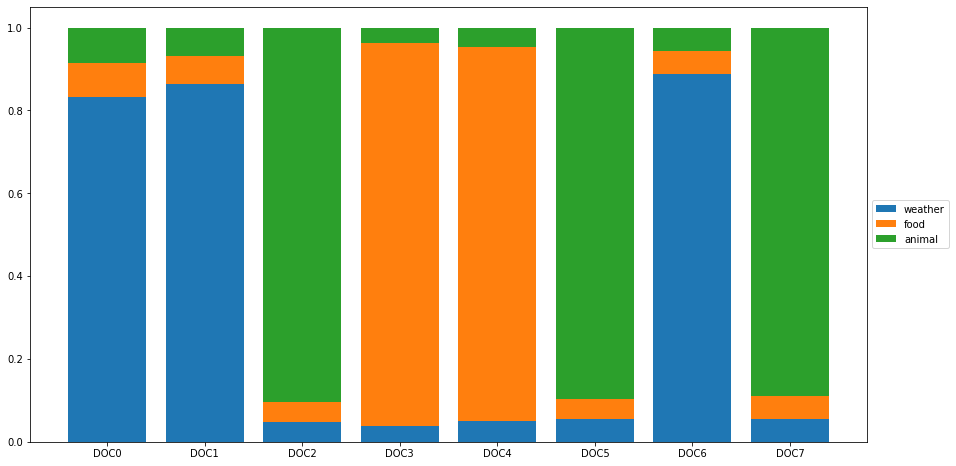

In [19]:
## create stacked bar plot
x_axis = ['DOC' + str(i) for i in range(len(norm_corpus))]
y_axis = doc_topic_df[['weather', 'food', 'animal']]

fig, ax = plt.subplots(figsize=(15, 8))

# Create stacked bar plot
bottom = np.zeros(len(x_axis))
for col in y_axis.columns:
    ax.bar(x_axis, y_axis[col], bottom=bottom, label=col)
    bottom += np.array(y_axis[col])

# Move the legend outside of the chart
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Clustering documents using topic model features

- We can use the topic distributions of each document as our features to further group the documents into clusters.
- Here is a quick example of k-means clustering.

In [21]:
## initialize kmeans
km = KMeans(n_clusters=3, random_state=0)

## fit kmeans
km.fit_transform(doc_topic_matrix)

## get cluster labels

cluster_labels = km.labels_

## check results
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,ClusterLabel
0,The sky is blue and beautiful.,2
1,Love this blue and beautiful sky!,2
2,The quick brown fox jumps over the lazy dog.,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",0
4,"I love green eggs, ham, sausages and bacon!",0
5,The brown fox is quick and the blue dog is lazy!,1
6,The sky is very blue and the sky is very beautiful today,2
7,The dog is lazy but the brown fox is quick!,1


## Visualizing Topic Models

In [22]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.lda_model ## for sklearn LDA; if gensim, use `pyLDAvis.gensim`
import dill
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pyLDAvis.enable_notebook()

In [23]:
## This block is to fix the pyLDAvis style issue
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))


In [24]:
cv_matrix = cv.fit_transform(norm_corpus)
pyLDAvis.lda_model.prepare(lda, cv_matrix, cv, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.008446  0.169018       1        1  38.698580
1      0.134621 -0.085246       2        1  33.674475
0     -0.126175 -0.083772       3        1  27.626945, topic_info=         Term      Freq     Total Category  logprob  loglift
17        sky  3.000000  3.000000  Default  20.0000  20.0000
2   beautiful  2.000000  2.000000  Default  19.0000  19.0000
3        blue  3.000000  3.000000  Default  18.0000  18.0000
13       lazy  2.000000  2.000000  Default  17.0000  17.0000
5       brown  2.000000  2.000000  Default  16.0000  16.0000
..        ...       ...       ...      ...      ...      ...
13       lazy  0.212021  2.793123   Topic3  -4.0259  -1.2919
8         fox  0.212021  2.793123   Topic3  -4.0259  -1.2919
15      quick  0.212021  2.793123   Topic3  -4.0259  -1.2919
6         dog  0.212021  2.793123   Topic3  -4.0259  -1.2919
5       brown  0.212021  2.793123   Topic3  -4.0259  -1.2919

[80 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.961000      bacon
1         2  0.724338      beans
2         3  0.773676  beautiful
3         1  0.304268       blue
3         3  0.608536       blue
4         2  0.724338  breakfast
5         1  0.716044      brown
6         1  0.716044        dog
7         2  0.961000       eggs
8         1  0.716044        fox
9         2  0.724342      green
10        2  0.961000        ham
11        1  0.722361      jumps
12        2  0.724338      kings
13        1  0.716044       lazy
14        2  0.496084       love
14        3  0.496084       love
15        1  0.716044      quick
16        2  0.961000   sausages
17        3  0.931661        sky
18        2  0.724338      toast
19        3  0.760429      today, R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

## Hyperparameter Tuning

- One thing we haven't made explicit is that the **number of topics** so far has been pre-determined before the analysis.
- How to find the optimal number of topics can be challenging in topic modeling.
- We can take this as a hyperparameter of the model and use **Grid Search** to find the most optimal number of topics.
- Similarly, we can fine tune the other hyperparameters of LDA as well (e.g., `learning_decay`).

- `learning_method`: The default is `batch`; that is, use all training data for parameter estimation. If it is `online`, the model will update the parameters on a token by token basis.
- `learning_decay`: If the `learning_method` is `online`, we can specify a parameter that controls learning rate in the online learning method (usually set between [0.5, 1.0]). 

:::{tip}

Doing Grid Search with LDA models can be very slow. There are some other topic modeling algorithms that are a lot faster. Please refer to Sarkar (2019) Chapter 6 for more information.

:::

### Grid Search for Topic Number

In [26]:
%%time

## Prepare hyperparameters dict
search_params = {'n_components': range(3,8), 'learning_decay': [.5, .7]}

## Initialize LDA
model = LatentDirichletAllocation(learning_method='batch', ## `online` for large datasets
                                  max_iter=10000,
                                  random_state=0)

## Gridsearch
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(cv_matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2.11 s, sys: 13.2 ms, total: 2.12 s
Wall time: 14.2 s


In [27]:
# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)
print('Best Model Perplexity: ', best_lda.perplexity(cv_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -50.410868132698795
Best Model Perplexity:  25.292966412842105


### Examining the Grid Search Results

In [28]:
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.534712,0.342016,0.000322,0.000025,0.5,3,"{'learning_decay': 0.5, 'n_components': 3}",-45.022883,-73.947625,-60.589126,-37.947911,-34.546796,-50.410868,14.789188,1
1,2.991487,0.781605,0.000419,0.000197,0.5,4,"{'learning_decay': 0.5, 'n_components': 4}",-49.145599,-82.726223,-65.081852,-42.126564,-37.038050,-55.223657,16.689926,3
2,2.830407,0.823932,0.000411,0.000164,0.5,5,"{'learning_decay': 0.5, 'n_components': 5}",-50.024617,-86.998110,-70.381182,-44.942218,-42.224895,-58.914204,17.163750,5
3,2.613521,0.476992,0.000515,0.000262,0.5,6,"{'learning_decay': 0.5, 'n_components': 6}",-52.609495,-93.522521,-73.924983,-47.956165,-49.996366,-63.601906,17.621249,7
4,2.508645,0.242184,0.000381,0.000128,0.5,7,"{'learning_decay': 0.5, 'n_components': 7}",-54.878310,-99.846527,-77.129032,-50.917763,-46.861191,-65.926565,19.934270,9
5,2.602352,0.392834,0.000512,0.000230,0.7,3,"{'learning_decay': 0.7, 'n_components': 3}",-45.022883,-73.947625,-60.589126,-37.947911,-34.546796,-50.410868,14.789188,1
6,2.955229,0.633029,0.000425,0.000211,0.7,4,"{'learning_decay': 0.7, 'n_components': 4}",-49.145599,-82.726223,-65.081852,-42.126564,-37.038050,-55.223657,16.689926,3
7,2.843962,0.751603,0.000349,0.000029,0.7,5,"{'learning_decay': 0.7, 'n_components': 5}",-50.024617,-86.998110,-70.381182,-44.942218,-42.224895,-58.914204,17.163750,5
8,2.597273,0.372056,0.000321,0.000039,0.7,6,"{'learning_decay': 0.7, 'n_components': 6}",-52.609495,-93.522521,-73.924983,-47.956165,-49.996366,-63.601906,17.621249,7
9,2.111250,0.215773,0.000330,0.000028,0.7,7,"{'learning_decay': 0.7, 'n_components': 7}",-54.878310,-99.846527,-77.129032,-50.917763,-46.861191,-65.926565,19.934270,9


<Axes: xlabel='param_n_components', ylabel='mean_test_score'>

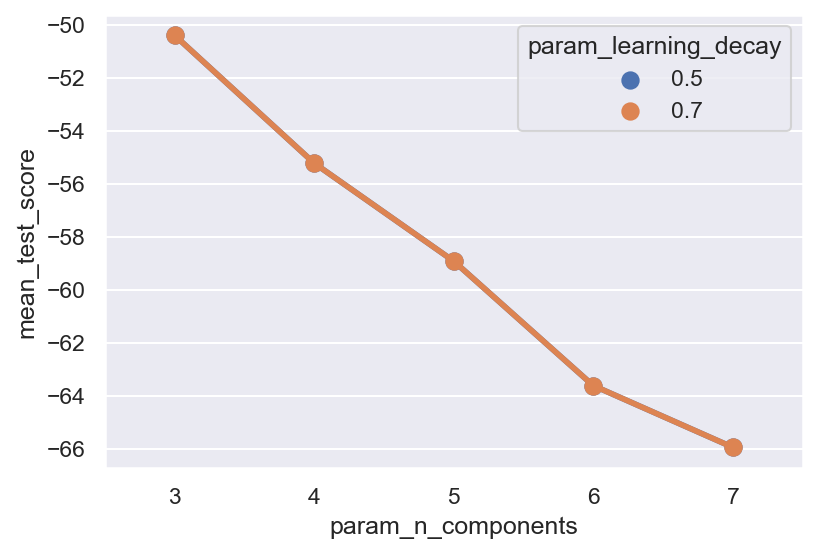

In [29]:
import seaborn as sns
sns.set_theme(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              hue="param_learning_decay",
              data=cv_results_df)

In [30]:
get_topics_meanings(best_lda.components_,
                    vocab,
                    display_weights=True,
                    weight_cutoff=2)

Topic #0 :
[('sky', 4.33), ('blue', 3.37), ('beautiful', 3.33)]
Topic #1 :
[('bacon', 2.33), ('eggs', 2.33), ('ham', 2.33), ('sausages', 2.33)]
Topic #2 :
[('brown', 3.33), ('dog', 3.33), ('fox', 3.33), ('lazy', 3.33), ('quick', 3.33)]


## Topic Prediction

- We can use our LDA to make predictions of topics for new documents.
- We need to perform the same procedures with the new document as we did with the training data:
    - text preprocessing
    - count-vectorization

In [32]:
new_texts = ['The sky is so blue', 'Love burger with ham']

## normalize
new_texts_norm = normalize_corpus(new_texts)

## vectorize
new_texts_cv = cv.transform(new_texts_norm)

## Check
new_texts_cv.shape

(2, 20)

In [33]:
## Applied our trained LDA
new_texts_doc_topic_matrix = best_lda.transform(new_texts_cv)

## Check results
topics = ['weather', 'food', 'animal']


new_texts_doc_topic_df = pd.DataFrame(new_texts_doc_topic_matrix,
                                      columns=topics)
new_texts_doc_topic_df['predicted_topic'] = [
    topics[i] for i in np.argmax(new_texts_doc_topic_df.values, axis=1)
]

new_texts_doc_topic_df['corpus'] = new_texts_norm
new_texts_doc_topic_df

,weather,food,animal,predicted_topic,corpus
0,0.775601,0.111301,0.113098,weather,sky blue
1,0.123415,0.764965,0.111620,food,love burger ham


## Additional Notes

- We can calculate a metric to evaluate the coherence of each topic.
- The coherence computation is implemented in `gensim`. To apply the coherence comptuation to a `sklearn`-trained LDA, we need `tmtoolkit` (`tmtoolkit.topicmod.evaluate.metric_coherence_gensim`).

- I leave notes here in case in the future we need to compute the coherence metrics.

:::{warning}

`tmtoolkit` does not support `spacy` 3+. Also, `tmtoolkit` will downgrade several important packages to lower versions. Please use it with caution. I would suggest creating another virtual environment for this.

:::

- The following codes demonstrate how to find the optimal topic number based on the coherence scores of the topic models.

In [ ]:
# Step 5: Calculate Coherence
coherence_model = CoherenceModel(topics=top_words_per_topic, texts=tokenized_text, dictionary=feature_names, coherence='c_v')
coherence_score = coherence_model.get_coherence()


In [34]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(topic_num_start=2,
                                    topic_num_end=6,
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end):
        print(i)
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=10000,
                                            random_state=0)
        cur_lda.fit_transform(cv_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names_out()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

In [35]:
%%time
ts = 2
te = 10
models, coherence_scores = topic_model_coherence_generator(
    ts, te, norm_corpus=norm_corpus, cv=cv, cv_matrix=cv_matrix)

2
3
4
5
6
7
8
9
CPU times: user 17.5 s, sys: 463 ms, total: 18 s
Wall time: 45.8 s


In [36]:
coherence_scores

[0.6517493196892892,
 0.8866946211961687,
 0.765479848024043,
 0.8341252576008902,
 0.8572203857656319,
 0.7066394264220808,
 0.6391495323490347,
 0.6086551968156503]

In [37]:
coherence_df = pd.DataFrame({
    'TOPIC_NUMBER': [str(i) for i in range(ts, te)],
    'COHERENCE_SCORE': np.round(coherence_scores, 4)
})

coherence_df.sort_values(by=["COHERENCE_SCORE"], ascending=False)

,TOPIC_NUMBER,COHERENCE_SCORE
1,3,0.8867
4,6,0.8572
3,5,0.8341
2,4,0.7655
5,7,0.7066
0,2,0.6517
6,8,0.6391
7,9,0.6087


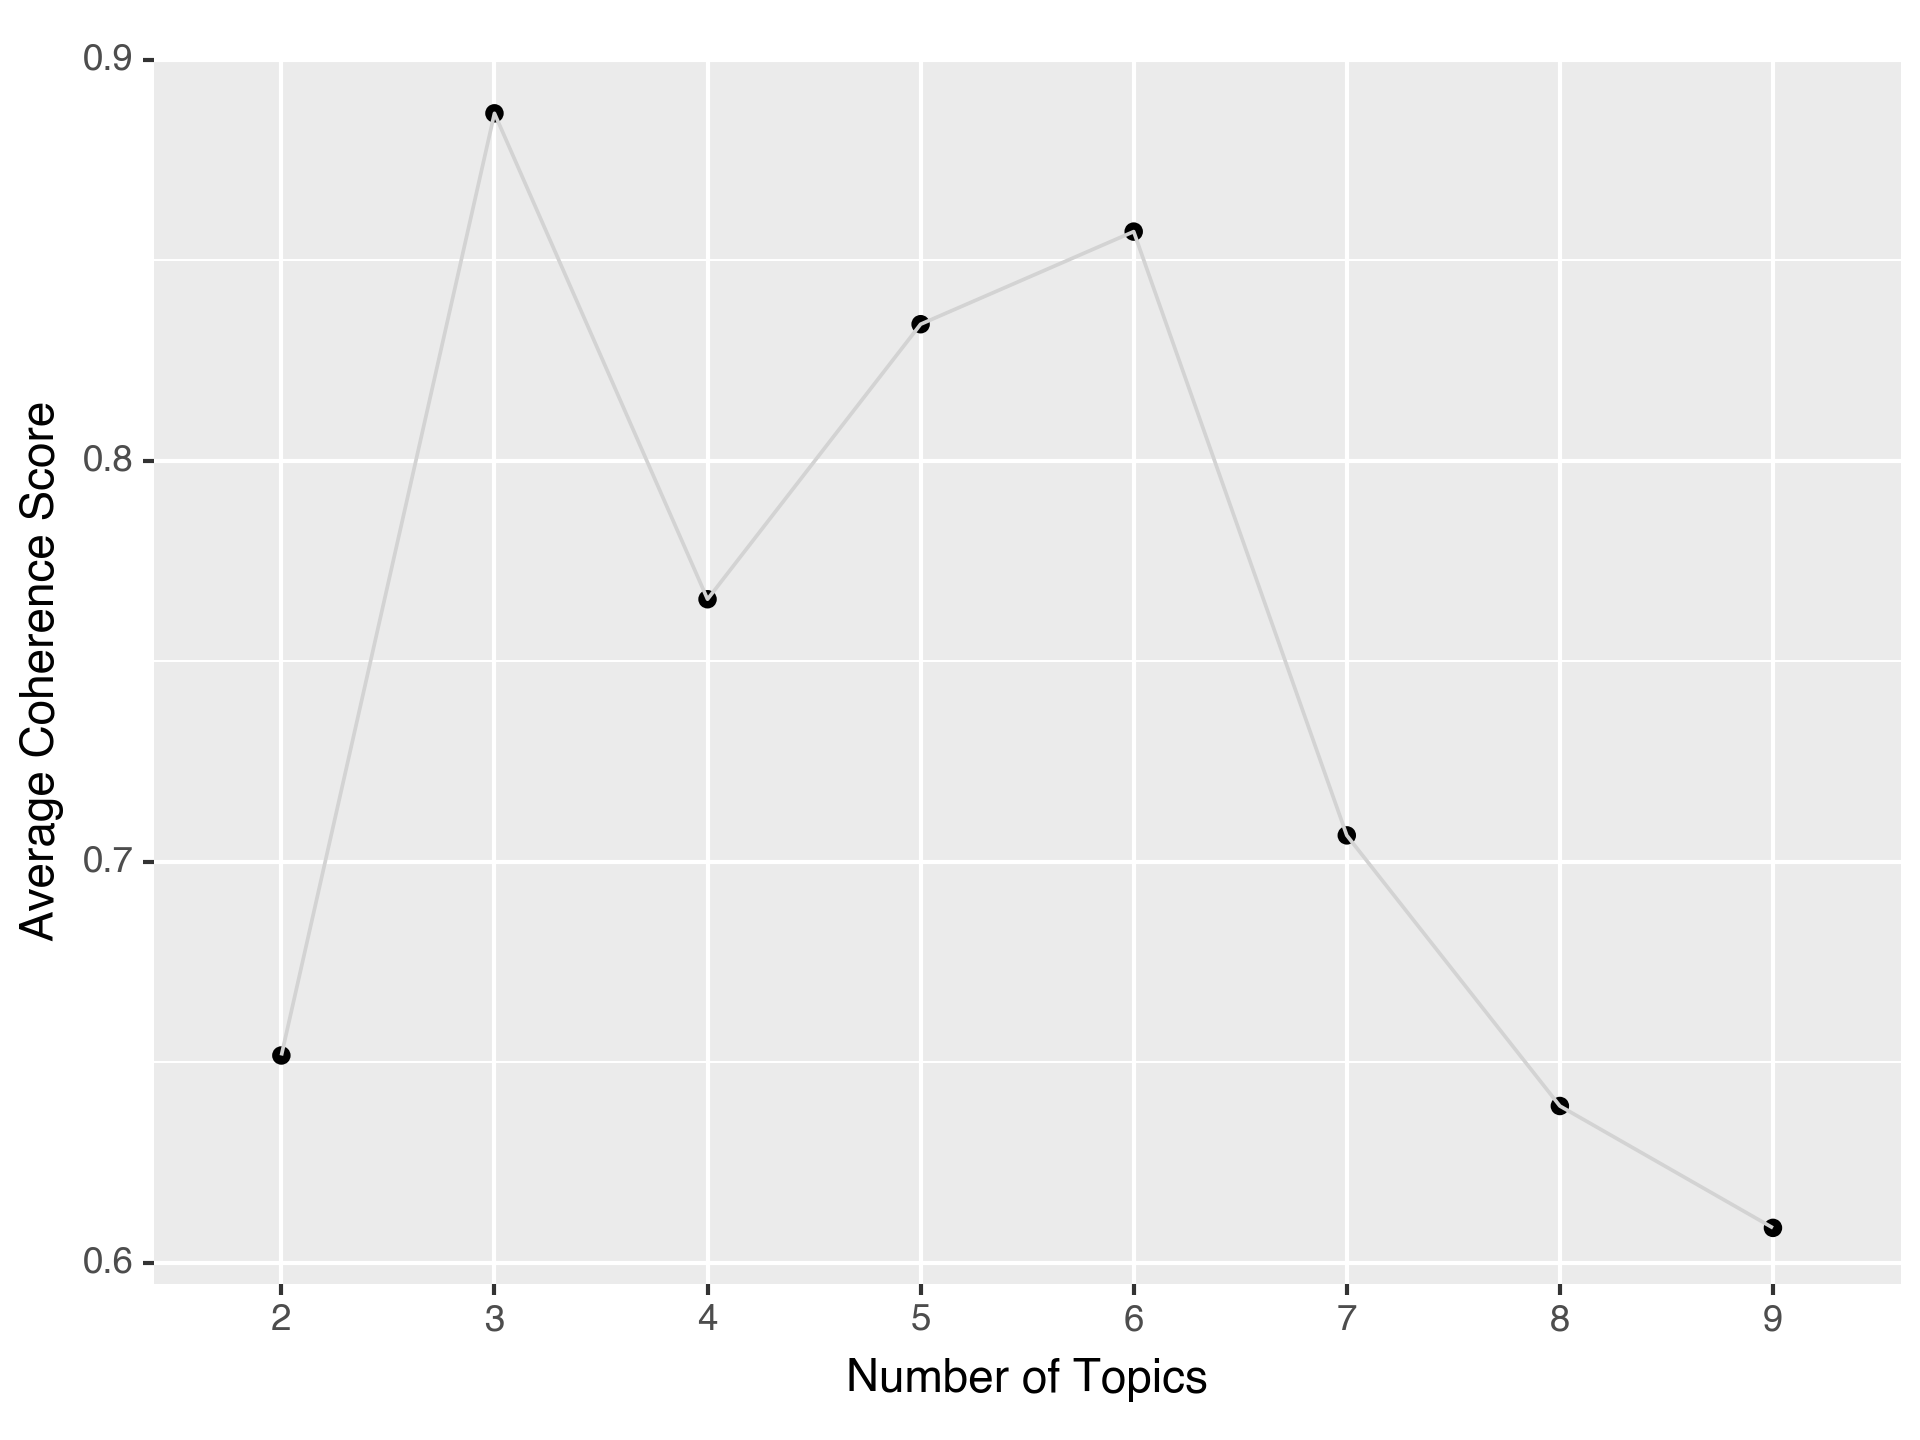

<Figure Size: (960 x 720)>

In [38]:
import plotnine
from plotnine import ggplot, aes, geom_point, geom_line, labs
plotnine.options.dpi = 150

g = (ggplot(coherence_df) + aes(x="TOPIC_NUMBER", y="COHERENCE_SCORE") +
     geom_point(stat="identity") + geom_line(group=1, color="lightgrey") +
     labs(x="Number of Topics", y="Average Coherence Score"))
g

## Challenges

- There are several challenges and limications with LDA:

    - Choosing the number of topics
    - Interpretability
    - Scalability
    - Polysemy and context

- Maybe we can combine this exploratory method of topic model with LLM by feeding the key terms of topics to the LLM to prompt for more comprehensive desciption and interpretation of the topics.




## References

- Sarkar (2019), Chapter 6: Text Summarization and Topic Models
- [Latent Dirichlet Allocation (LDA) and Topic Modeling: Models, Applications, and a Survey](https://arxiv.org/abs/1711.04305)